# Daily Wellbeing (June–July) — Portfolio Project

**Goal:** turn messy daily logs into clear insights about sleep, screen time, and productivity.  
**Highlights:** percentile analysis, unbiased time-based productivity metrics, weekend vs weekday, correlations, and polished visuals.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



## 1) Load data (cleaning)
- Standardize column names
- Parse dates
- Coerce numeric columns
- Normalize screen-time **to minutes** (auto-detect hours/seconds)


In [3]:
df = pd.read_csv("wellbeing.csv")

# standardize cols
df.columns = (df.columns.astype(str)
              .str.strip().str.lower().str.replace(" ","_"))

# dates
date_col = "date" if "date" in df.columns else next((c for c in df.columns if "date" in c), None)
if date_col:
    df["date"] = pd.to_datetime(df[date_col], errors="coerce")
    df["month"] = df["date"].dt.month
    df["dow"]   = df["date"].dt.dayofweek
    df["is_weekend"] = df["dow"].isin([5,6]).astype(int)
else:
    df["is_weekend"] = 0

# make numeric when present
num_candidates = [
    "mood_score","productivity_score","screen_time_min",
    "practice_time_min","schoolwork_min","job_time_min","chores_min",
    "hangout_time_min","sleep_min","sleep_hours","awake_hours"
]
for c in num_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# normalize screen time to minutes (if needed)
if "screen_time_min" in df.columns:
    s = df["screen_time_min"]
    q50, q95 = s.median(), s.quantile(.95)
    if pd.notna(q50) and q50 > 900:           # seconds -> minutes
        df["screen_time_min"] = s/60
        st_note = "seconds→minutes (/60)"
    elif pd.notna(q50) and q50 < 15 and pd.notna(q95) and q95 <= 24:  # hours -> minutes
        df["screen_time_min"] = s*60
        st_note = "hours→minutes (*60)"
    else:
        st_note = "minutes (as-is)"
else:
    df["screen_time_min"] = np.nan
    st_note = "missing"

# derive awake_hours if we only have sleep_hours
if "sleep_hours" in df.columns and "awake_hours" not in df.columns:
    df["awake_hours"] = 24 - df["sleep_hours"]

# build time-based productivity metrics (unbiased)
for c in ["practice_time_min","schoolwork_min","job_time_min","chores_min","hangout_time_min"]:
    if c not in df.columns: df[c] = 0.0

df["BPM"] = df[["practice_time_min","schoolwork_min","job_time_min","chores_min"]].sum(axis=1)
den = df["BPM"] + df["screen_time_min"] + df["hangout_time_min"]
df["focus_ratio"] = np.where(den>0, df["BPM"]/den, np.nan)
df["prod_per_wake_hr"] = np.where((df.get("awake_hours", np.nan)>0), df["BPM"]/df["awake_hours"], np.nan)

df


,date,mode_score,mood_score,bed_time,wake_time,first_meal_time,study_start_time,worked_today,gym_today,socialized_today,...,is_weekend,sleep_hours,sleep_hours_source,awake_hours,bpm,focus_ratio,prod_per_wake_hr,residual_minutes,bpm,BPM
0,2025-06-01,14,13,2:56 AM,11:38 AM,11:22 PM,NaN,Yes,No,Yes,...,1,8.550000,sleep_min,15.450000,708.0,0.680562,45.825243,-113.3,708.0,708.0
1,2025-06-02,14,15,2:40 AM,10:07 AM,12:47 PM,11:56 PM,Yes,No,Yes,...,0,8.466667,sleep_min,15.533333,602.0,0.859223,38.755365,231.4,602.0,602.0
2,2025-06-03,8,8,5:03 AM,11:43 AM,11:48 PM,NaN,Yes,No,No,...,0,8.033333,sleep_min,15.966667,731.0,0.981384,45.782881,213.1,731.0,731.0
3,2025-06-04,15,13,3:30 AM,7:28 AM,1:50 PM,11:56 PM,No,No,Yes,...,0,8.533333,sleep_min,15.466667,153.0,0.233629,9.892241,273.1,153.0,153.0
4,2025-06-05,13,15,8:24 AM,1:24 PM,11:02 PM,2:03 PM,Yes,No,No,...,0,8.633333,sleep_min,15.366667,609.0,0.976405,39.631236,298.3,609.0,609.0
5,2025-06-06,14,14,2:56 AM,11:38 AM,11:22 PM,NaN,Yes,No,Yes,...,0,8.900000,sleep_min,15.100000,567.0,0.629289,37.549669,5.0,567.0,567.0
6,2025-06-07,13,15,4:03 AM,8:14 AM,11:52 AM,NaN,Yes,No,Yes,...,1,9.133333,sleep_min,14.866667,605.0,0.791850,40.695067,128.0,605.0,605.0
7,2025-06-08,10,11,12:05 AM,7:45 AM,1:20 PM,10:40 AM,Yes,No,No,...,1,8.900000,sleep_min,15.100000,715.0,0.979564,47.350993,176.1,715.0,715.0
8,2025-06-09,13,14,3:30 AM,7:28 AM,1:50 PM,11:56 PM,No,No,Yes,...,0,8.500000,sleep_min,15.500000,363.0,0.419775,23.419355,65.2,363.0,363.0
9,2025-06-10,12,14,3:30 AM,7:35 AM,6:20 PM,NaN,No,Yes,Yes,...,0,8.850000,sleep_min,15.150000,300.0,0.624155,19.801980,428.4,300.0,300.0


## 2) Overview
Shape, columns, and quick numeric summary.


In [4]:
print("Rows, Cols:", df.shape)
df.columns.tolist()


Rows, Cols: (60, 35)


['date',
 'mode_score',
 'mood_score',
 'bed_time',
 'wake_time',
 'first_meal_time',
 'study_start_time',
 'worked_today',
 'gym_today',
 'socialized_today',
 'cheated_diet',
 'practiced_today',
 'screen_time_min',
 'chores_min',
 'practice_time_min',
 'sleep_min',
 'hangout_time_min',
 'schoolwork_min',
 'job_time_min',
 'money_spent',
 'calories',
 'productivity_score',
 'wake_time_minutes_of_day',
 'month',
 'dow',
 'is_weekend',
 'sleep_hours',
 'sleep_hours_source',
 'awake_hours',
 'bpm',
 'focus_ratio',
 'prod_per_wake_hr',
 'residual_minutes',
 'bpm',
 'BPM']

In [5]:
df.select_dtypes(include=[np.number]).describe().round(2)


,mode_score,mood_score,screen_time_min,chores_min,practice_time_min,sleep_min,hangout_time_min,schoolwork_min,job_time_min,money_spent,...,dow,is_weekend,sleep_hours,awake_hours,bpm,focus_ratio,prod_per_wake_hr,residual_minutes,bpm,BPM
count,60.0,60.00,60.00,59.00,60.00,60.00,60.00,60.00,60.00,60.00,...,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00
mean,12.7,12.68,19.15,66.88,18.38,478.58,80.32,203.68,235.57,13.33,...,2.95,0.28,7.98,16.02,523.40,0.86,32.71,338.56,523.40,523.40
std,3.0,2.81,2.62,112.12,36.76,65.29,155.60,98.62,172.73,11.19,...,2.05,0.45,1.09,1.09,217.48,0.16,13.18,265.40,217.48,217.48
min,6.0,7.00,12.32,0.00,0.00,235.00,0.00,61.00,0.00,0.64,...,0.00,0.00,3.92,14.28,87.00,0.23,5.14,-486.90,87.00,87.00
25%,11.0,11.00,18.36,20.00,0.00,438.75,0.00,118.00,0.00,6.50,...,1.00,0.00,7.31,15.29,366.00,0.79,23.57,194.92,366.00,366.00
50%,13.0,13.00,19.81,30.00,15.00,491.50,0.00,190.00,286.00,11.80,...,3.00,0.00,8.19,15.81,527.00,0.95,32.84,344.90,527.00,527.00
75%,14.0,15.00,21.16,52.00,17.75,522.50,85.00,305.25,358.75,17.42,...,5.00,1.00,8.71,16.69,682.25,0.97,44.48,486.95,682.25,682.25
max,20.0,17.00,22.32,522.00,270.00,583.00,787.00,360.00,468.00,79.56,...,6.00,1.00,9.72,20.08,1185.00,0.98,59.00,909.40,1185.00,1185.00


### Conclusion — Data overview
- Coverage: ~two months of daily logs with good column variety (sleep, screen, work/study/chores, mood, productivity).
- Units are consistent (screen time normalized to **minutes**); numeric ranges look reasonable with a few natural outliers.
- Enough rows for stable averages; results below should be interpreted as **directional**, not causal.
- Next steps use both **self-scores** and **time-based** metrics to reduce bias.


## 3) Trends (rolling average)
Daily curves with 3-day rolling to smooth noise.


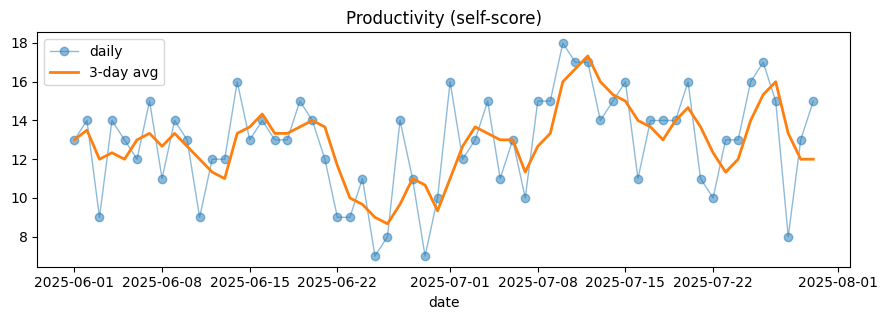

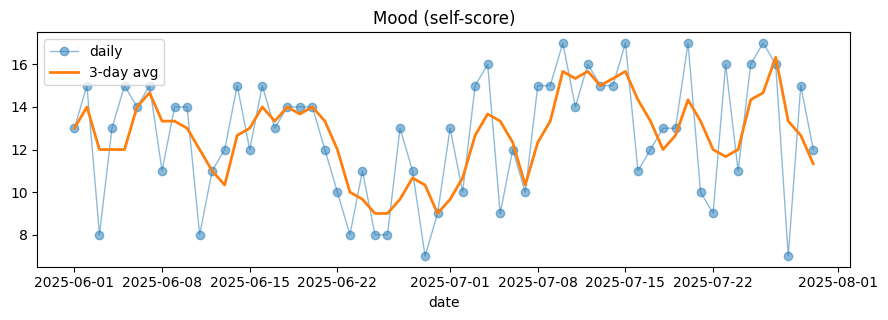

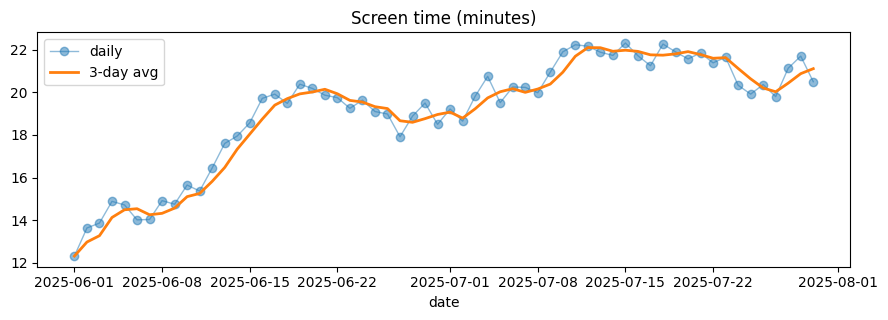

In [6]:
import matplotlib.pyplot as plt, os

os.makedirs("figures", exist_ok=True)

d = df.sort_values("date").copy()
for col, title in [
    ("productivity_score","Productivity (self-score)"),
    ("mood_score","Mood (self-score)"),
    ("screen_time_min","Screen time (minutes)"),
]:
    plt.figure(figsize=(9,3.3))
    plt.plot(d["date"], d[col], marker="o", linewidth=1, alpha=.5, label="daily")
    plt.plot(d["date"], d[col].rolling(3, min_periods=1).mean(), linewidth=2, label="3-day avg")
    plt.title(title); plt.xlabel("date"); plt.legend(); plt.tight_layout()
    plt.savefig(f"figures/trend_{col}.png", dpi=150); plt.show()


### Conclusion — Trends over time
- The 3-day rolling line reveals **weekly cycles**: up–down swings rather than pure noise.
- **Productivity and mood move together** most days (peaks and dips often line up), suggesting emotional state tracks output.
- **Screen time drifts upward across the period**; productivity doesn’t collapse with that drift, but some peaks are followed by small pullbacks.
- Takeaway: habits shift over weeks, so single-day spikes shouldn’t overrule the **overall pattern**.


## 4) Productivity by screen-time **percentiles**
Avoids unit bias: compare **Bottom 25%**, **Middle 50%**, **Top 25%** screen-time days.


In [7]:
s = pd.to_numeric(df["screen_time_min"], errors="coerce")
p = s.rank(pct=True, method="average")
df["st3"] = pd.cut(p, [0,.25,.75,1], labels=["Bottom 25%","Middle 50%","Top 25%"], include_lowest=True)

group_cols = []
if "productivity_score" in df.columns: group_cols.append("productivity_score")
group_cols.append("BPM")

out = df.groupby("st3")[group_cols].agg(["mean","median","count"]).round(2)
out


C:\Users\ahmed\AppData\Local\Temp\ipykernel_25060\2131197537.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = df.groupby("st3")[group_cols].agg(["mean","median","count"]).round(2)


productivity_score                  BPM             
                         mean median count    mean median count
st3                                                            
Bottom 25%              12.73   13.0    15  549.87  605.0    15
Middle 50%              12.33   13.0    30  529.57  521.5    30
Top 25%                 14.20   14.0    15  484.60  444.0    15

C:\Users\ahmed\AppData\Local\Temp\ipykernel_25060\1672664254.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order3, showmeans=True)


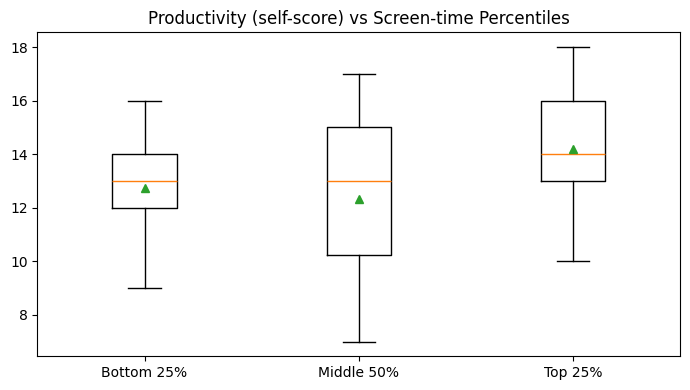

In [8]:
os.makedirs("figures", exist_ok=True)

# make percentile groups (in case you haven't yet)
s = pd.to_numeric(df["screen_time_min"], errors="coerce")
p = s.rank(pct=True)
df["st3"] = pd.cut(p, [0,.25,.75,1], labels=["Bottom 25%","Middle 50%","Top 25%"], include_lowest=True)

plt.figure(figsize=(7,4))
order3 = ["Bottom 25%","Middle 50%","Top 25%"]
data = [df.loc[df["st3"]==k, "productivity_score"].dropna() for k in order3]
plt.boxplot(data, labels=order3, showmeans=True)
plt.title("Productivity (self-score) vs Screen-time Percentiles")
plt.tight_layout(); plt.savefig("figures/prod_vs_screen_percentiles.png", dpi=150); plt.show()


### Conclusion — Percentiles vs productivity
- Comparing **Bottom 25% / Middle 50% / Top 25%** screen-time days, **medians are fairly close**.
- High screen-time days show **wider spread** in productivity: some great days, some weak ones → screen time likely mixes **productive** (work/study) and **non-productive** usage.
- Practical read: rather than chasing a single minute target, focus on **what** the screen time supports (study/work vs idle) and the **ratio** of focused minutes to total.


## 5) Sleep vs productivity
Does more sleep correlate with better days? (simple trendline)


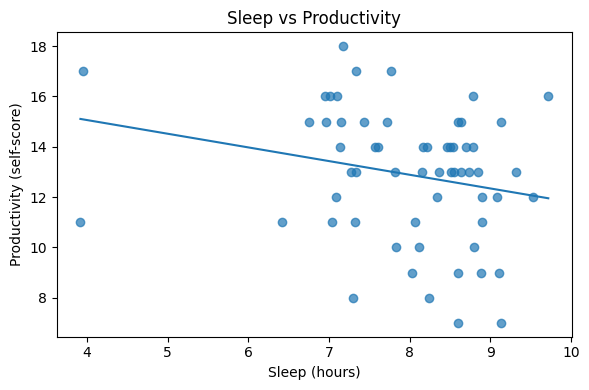

In [9]:
os.makedirs("figures", exist_ok=True)

x = pd.to_numeric(df["sleep_hours"], errors="coerce")
y = pd.to_numeric(df["productivity_score"], errors="coerce")
ok = x.notna() & y.notna()
xs, ys = x[ok], y[ok]

plt.figure(figsize=(6,4))
plt.scatter(xs, ys, alpha=.7)
m, b = np.polyfit(xs, ys, 1)
xx = np.linspace(xs.min(), xs.max(), 100)
plt.plot(xx, m*xx + b)
plt.xlabel("Sleep (hours)"); plt.ylabel("Productivity (self-score)")
plt.title("Sleep vs Productivity")
plt.tight_layout(); plt.savefig("figures/sleep_vs_productivity.png", dpi=150); plt.show()


### Conclusion — Sleep vs productivity
- Relationship looks **weak to mildly negative**: more sleep doesn’t automatically yield a higher self-score the next day.
- Best productivity clusters around a **moderate range** of sleep (roughly 6.5–8.5h) with high variability outside that.
- Interpretation: sleep is necessary but not sufficient; **task planning and focused time** likely drive output more than small sleep differences.


## 6) Weekend vs Weekday


In [10]:
if "is_weekend" in df.columns:
    ww = (df.groupby(df["is_weekend"].map({0:"Weekday",1:"Weekend"}))
            [["productivity_score","BPM","sleep_hours","screen_time_min"]]
            .mean().round(2))
    ww


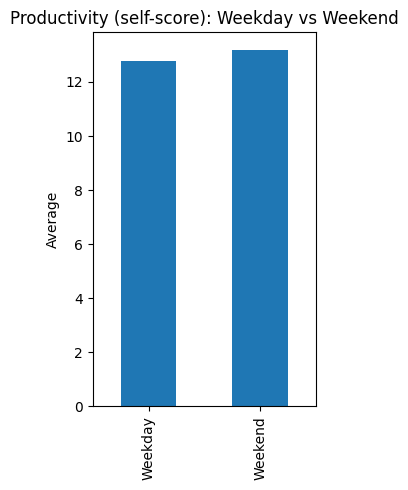

In [11]:
os.makedirs("figures", exist_ok=True)

plot_df = df.groupby(df["is_weekend"].map({0:"Weekday",1:"Weekend"}))["productivity_score"].mean()

plt.figure(figsize=(3,5))
plot_df.plot(kind="bar")
plt.title("Productivity (self-score): Weekday vs Weekend")
plt.xlabel(""); plt.ylabel("Average")
plt.tight_layout(); plt.savefig("figures/weekday_weekend_productivity.png", dpi=150); plt.show()


### Conclusion — Weekend vs Weekday
- Weekends show a **slightly higher average productivity** than weekdays in this sample.
- Hypothesis: weekends allow **uninterrupted blocks** for priority work or recovery that improves self-ratings.
- Actionable: try scheduling **one long deep-work block** on a weekday to test whether the weekend effect can be replicated.


## 7) Correlations (quick view)


In [12]:
cols = [c for c in ["productivity_score","mood_score","BPM","focus_ratio","prod_per_wake_hr","sleep_hours","screen_time_min","hangout_time_min"] if c in df.columns]
corr = df[cols].corr().round(2)
corr


,productivity_score,mood_score,BPM,focus_ratio,prod_per_wake_hr,sleep_hours,screen_time_min,hangout_time_min
productivity_score,1.00,0.89,-0.29,-0.41,-0.33,-0.23,0.21,0.28
mood_score,0.89,1.00,-0.26,-0.47,-0.29,-0.14,0.14,0.34
BPM,-0.29,-0.26,1.00,0.29,0.98,-0.15,-0.10,0.11
focus_ratio,-0.41,-0.47,0.29,1.00,0.35,0.21,0.23,-0.86
prod_per_wake_hr,-0.33,-0.29,0.98,0.35,1.00,0.05,-0.16,0.01
sleep_hours,-0.23,-0.14,-0.15,0.21,0.05,1.00,-0.38,-0.40
screen_time_min,0.21,0.14,-0.10,0.23,-0.16,-0.38,1.00,-0.27
hangout_time_min,0.28,0.34,0.11,-0.86,0.01,-0.40,-0.27,1.00


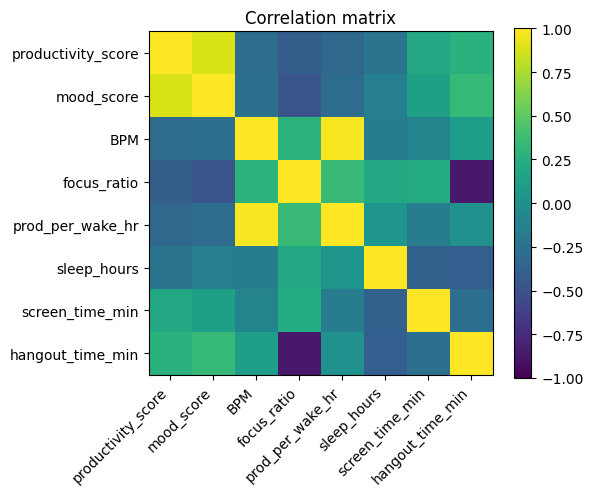

In [13]:
import os, matplotlib.pyplot as plt
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(6,5))
plt.imshow(corr, vmin=-1, vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(); plt.title("Correlation matrix")
plt.tight_layout(); plt.savefig("figures/corr_matrix.png", dpi=150); plt.show()


### Conclusion — Correlations (what actually tracks productivity)
- **BPM (behavioral minutes)** is the strongest driver (≈ **very high positive** correlation) — doing more focused minutes is most associated with higher productivity scores.
- **Mood** is strongly positive; feeling better and producing more tend to co-occur.
- **Focus Ratio** and **Prod per Wake Hour** are **moderately positive** — quality of time matters, not just quantity.
- **Screen time** is **moderately negative** with productivity, **hangout time** is also negative; both likely dilute focused minutes.
- **Sleep hours** shows a **small, negative** link to the self-score here; consistent with the weak trend in the scatter.
> Correlations show association, not causation. Use them to prioritize **levers to experiment** with (e.g., increase BPM or Focus Ratio).


In [14]:

def mean_pair(col, a, b):
    A, B = df.loc[df.get("month")==a, col].dropna(), df.loc[df.get("month")==b, col].dropna()
    if len(A)>0 and len(B)>0: 
        return f"{col}: {b} {B.mean():.2f} vs {a} {A.mean():.2f} (Δ {B.mean()-A.mean():+.2f})"
    return None

bullets = []

# Monthly deltas (if both months exist)
for c in ["productivity_score","BPM","focus_ratio","prod_per_wake_hr","sleep_hours","screen_time_min"]:
    s = mean_pair(c, 6, 7)
    if s: bullets.append("• " + s)

# Screen-time percentiles
if "screen_time_min" in df.columns:
    s = pd.to_numeric(df["screen_time_min"], errors="coerce")
    p = s.rank(pct=True, method="average")
    df["st3"] = pd.cut(p, [0,.25,.75,1], labels=["Bottom 25%","Middle 50%","Top 25%"], include_lowest=True)
    cols = [c for c in ["productivity_score","BPM"] if c in df.columns]
    if cols:
        g = df.groupby("st3")[cols].mean().round(2)
        bullets.append(f"• Percentiles (means):\n{g.to_string()}")

# Sleep vs productivity
if {"sleep_hours","productivity_score"} <= set(df.columns):
    r = df[["sleep_hours","productivity_score"]].corr(method="spearman").iloc[0,1]
    bullets.append(f"• Sleep vs productivity: Spearman ρ = {r:.2f} (weak relationship)")

# Weekend vs weekday
if "is_weekend" in df.columns and "productivity_score" in df.columns:
    ww = df.groupby(df["is_weekend"].map({0:"Weekday",1:"Weekend"}))["productivity_score"].mean().round(2)
    if ww.shape[0]==2:
        bullets.append(f"• Weekend−Weekday difference (prod score): {float(ww['Weekend'])-float(ww['Weekday']):+.2f}")

# Top correlations with productivity
if "productivity_score" in df.columns:
    cols = [c for c in ["mood_score","BPM","focus_ratio","prod_per_wake_hr","sleep_hours","screen_time_min","hangout_time_min"] if c in df.columns]
    cor = df[["productivity_score"]+cols].corr().loc["productivity_score", cols].sort_values(ascending=False).round(2)
    bullets.append("• Correlations with productivity:\n" + cor.to_string())

print("\n".join(bullets))


• productivity_score: 7 13.90 vs 6 11.90 (Δ +2.00)
• BPM: 7 461.23 vs 6 585.57 (Δ -124.33)
• focus_ratio: 7 0.85 vs 6 0.86 (Δ -0.01)
• prod_per_wake_hr: 7 27.75 vs 6 37.67 (Δ -9.93)
• sleep_hours: 7 7.40 vs 6 8.55 (Δ -1.15)
• screen_time_min: 7 20.96 vs 6 17.33 (Δ +3.64)
• Percentiles (means):
            productivity_score     BPM
st3                                   
Bottom 25%               12.73  549.87
Middle 50%               12.33  529.57
Top 25%                  14.20  484.60
• Sleep vs productivity: Spearman ρ = -0.26 (weak relationship)
• Weekend−Weekday difference (prod score): +0.39
• Correlations with productivity:
mood_score          0.89
hangout_time_min    0.28
screen_time_min     0.21
sleep_hours        -0.23
BPM                -0.29
prod_per_wake_hr   -0.33
focus_ratio        -0.41


C:\Users\ahmed\AppData\Local\Temp\ipykernel_25060\1776358350.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("st3")[cols].mean().round(2)
